In [1]:
### import modules
import numpy as np
from scipy.integrate import odeint
from utils import plot_timeseries

# Models

## SEIR Model
A basic SEIR model was used to simulate the spread of an infectious disease in a population that was not vaccinated. Note that we used normalized variables such that the total population $N = S + E + I + R = 1$.

### Equations
\begin{align*}
\dot{S} &= - \beta S I \\
\dot{E} &= \beta S I - \sigma E \\
\dot{I} &= \sigma E - \gamma I \\
\dot{R} &= \gamma I \\
\end{align*}


### Variables
- $S$: Fraction of susceptible individuals
- $E$: Fraction of exposed individuals
- $I$: Fraction of infected individuals
- $R$: Fraction of recovered individuals

### Parameters
- $\beta$: Infectiousness of infected individuals
- $\sigma$: Duration of the latent period
- $\gamma$: Duration of the infectious period

In [2]:
def seir (y, t, beta, sigma, gamma):
    """
    Basic SEIR model
    """
    s, e, i, r = y
    dsdt = - beta*s*i
    dedt = beta*s*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    
    return dsdt, dedt, didt, drdt

## Modified SEIR Model
We modified the above SEIR model to investigate two possible vaccine failure mechanisms - 'leaky' and 'all-or-nothing'. Note that similar to the SEIR Model above, all variables used were normalized such that $N = S + V_{S} + V_{R} + E + I + R = 1$.

### Equations
\begin{align*}
\dot{S} &= - \beta SI - v(t)S \\
\dot{V}_{S} &= (1 - \epsilon_A)v(t)S - \beta V_{S}I \\
\dot{V}_{R} &= \epsilon_A v(t)S - \beta(1-\epsilon_L)V_{R}I \\
\dot{E} &= \beta (S + V_S + (1 - \epsilon_L) V_R)I - \sigma E \\
\dot{I} &= \sigma E - \gamma I \\
\dot{R} &= \gamma I \\
\end{align*}

### Variables
- $S$: Fraction of susceptible and uninfected individuals
- $V_{S}$: Fraction of vaccinated and uninfected individuals who are equally as susceptible as unvaccinated individuals 
- $V_{R}$: Fraction of vaccinated and uninfected individuals who are less susceptible than unvaccinated individuals
- $E$: Fraction of exposed individuals who are not yet infected
- $I$: Fraction of infected individuals
- $R$: Fraction of recovered individuals

### Parameters
- $\beta$: Infectiousnes of infected individuals
- $v(t)$: Fraction of population vaccinated per unit time. For an instantaneous vaccination campaign at time $t_V$ that targets a fraction $f_V$ of the population, $v(t) = f_V \delta (t - t_V)$ where $\delta$ is the Kronecker delta function. For a continuous vaccine rollout beginning at time $t_V$ at initial rate $v_{max}$ and continuing until a fraction $f_V$ of the population are vaccinated, $v(t) = v_{max}H(t-t_V)(1 - \frac{V_S + V_R}{f_V})$ where $H$ is the Heaviside step function.
- $\epsilon_A$: Efficacy of 'all-or-nothing' protection
- $\epsilon_L$: Efficacy of 'leaky' protection
- $\sigma$: Duration of the latent period
- $\gamma$: Duration of the infectious period

In [3]:
def delta(t, tv):
    if (t > tv - 0.8) and (t < tv + 0.8):
        return 1
    else:
        return 0

In [25]:
def modified_seir(y, t, tv, beta, sigma, gamma, fv, epsL, epsA):
    """
    Modified SEIR model for instantaneous vaccination. 
    """
    s, v_s, v_r, e, i, r = y
    v = fv * delta(t, tv)
    
    dsdt = - beta*s*i - v*s
    dvsdt = (1-epsA)*v*s - beta*v_s*i
    dvrdt = epsA*v*s - beta*(1-epsL)*v_r*i
    dedt = beta*(s+v_s+(1-epsL)*v_r)*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i

    return dsdt, dvsdt, dvrdt, dedt, didt, drdt

## Basic Reproduction Number ($R_0$)

The basic reproduction number $R_0$ is defined as the average number of secondary cases produced by a single infected individual. This dimensionless number can be calculated by dividing the transmission rate of the disease by its recovery rate, as it represents the ratio of how fast the disease spreads to the expected duration of infection. $R_0$, in the absense of vaccination, is defined as:

$$ R_0 = \frac{\beta}{\gamma} N $$

where $N=1$ because we use normalized variables in this model. 

The $R_0$ value changes throughout the progression of the disease as interventions that lower the transmission rate are introduced, such as vaccination or quarantine. Thus, assuming vaccination of a fracton $f_V$ of the population takes place before the epidemic begins, the basic reproduction number for this model is:

$$ R_{0,V} = \frac{\beta}{\gamma} (1 - \epsilon_L \epsilon_A f_V) = R_0 (1 - \epsilon_L \epsilon_A f_V)$$


In [26]:
def run_modified_seir(y0: list, t: np.ndarray, tv: int, beta: float, sigma: float, gamma: float, fv: float, \
    eps: float, mode: str = 'leaky'):
    if mode == 'leaky':
        epsL = eps; epsA = 1
    elif mode == 'aon':
        epsL = 1; epsA = eps
    else:
        print("Mode must be 'leaky' or 'aon'.")

    sim = odeint(modified_seir, y0, t, args=(tv, beta, sigma, gamma, fv, epsL, epsA))
    s, v_s, v_r, e, i, r = sim.T
    v = v_s + v_r

    return s, v_s, v_r, v, e, i, r

# Time-Series Plots

## Pre-transmission Vaccination
We will assume that vaccination happens all at once for simplicity. Note that for a leaky vaccine, $\epsilon_A = 1$, and for an all-or-nothing vaccine, $\epsilon_L = 1$.

For the plots below, $\beta, \gamma, \sigma$ values were chosen based on the characteristics of COVID-19, and $\epsilon_L, \epsilon_A, v$ were arbitrary values that show the difference between the two vaccine failure mechanisms.

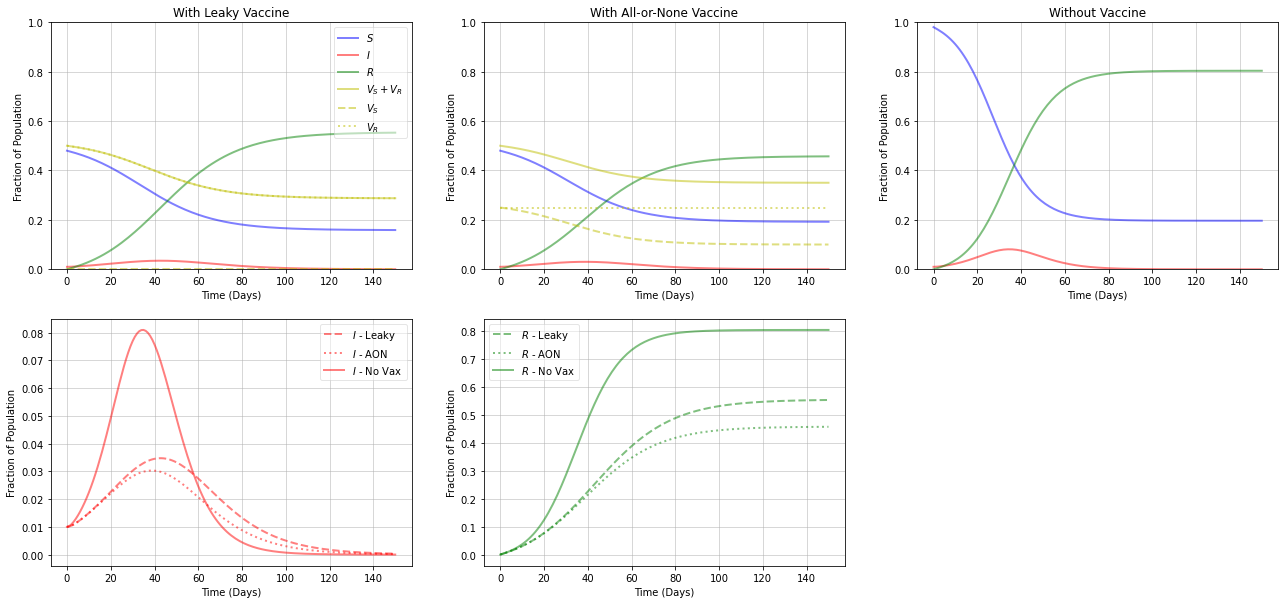

In [50]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2 * gamma; eps = 0.5; fv = 0.5
s0 = 0.98; s0_vax = 0.98 - fv; e0 = 0.01; i0 = 0.01; r0 = 0; 
t = np.linspace(0, 150, 151); tv = -1

# no vaccination
y0 = [s0, e0, i0, r0]
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
sim = sim.T

# leaky
vs0_leaky = 0; vr0_leaky = fv; y0_leaky = [s0_vax, vs0_leaky, vr0_leaky, e0, i0, r0]
sim_leaky = run_modified_seir(y0_leaky, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

# aon
vs0_aon = fv*(1-eps); vr0_aon = fv*eps; y0_aon = [s0_vax, vs0_aon, vr0_aon, e0, i0, r0]
sim_aon = run_modified_seir(y0_aon, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')

### plot time-series plot
plot_timeseries(sim, sim_leaky, sim_aon)

## 10 Days Post-transmission Vaccination

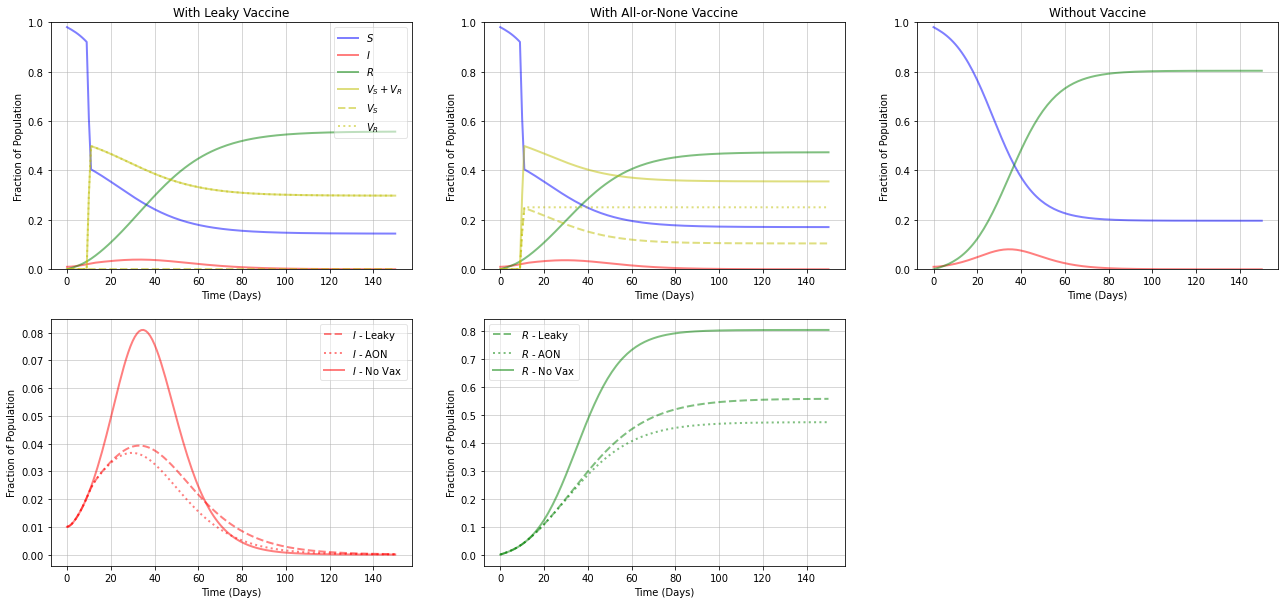

In [53]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2 * gamma; eps = 0.5; fv = 0.5
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, 150, 151); tv = 10

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
sim = sim.T

# leaky
sim_leaky = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

# aon
sim_aon = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')

### plot time-series plot
plot_timeseries(sim, sim_leaky, sim_aon)

## 30 Days Post-Transmission Vaccination

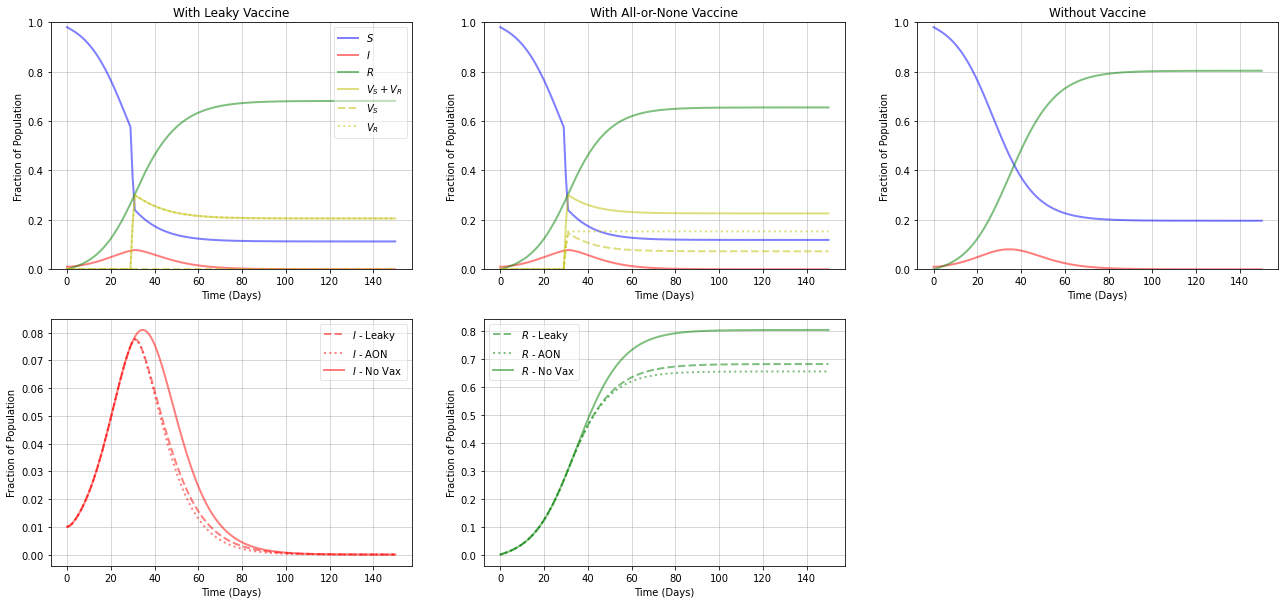

In [54]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2 * gamma; eps = 0.5; fv = 0.5
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, 150, 151); tv = 30

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
sim = sim.T

# leaky
sim_leaky = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

# aon
sim_aon = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')

### plot time-series plot
plot_timeseries(sim, sim_leaky, sim_aon)

## Conclusion

